# Path Analysis Solutions
#### Adam Gibbs     
#### 31 March 2022

This Python notebook contains the full analysis of the two log files path.csv and tracker.csv and attempts to generate as many insights into the errors as possible. A summary of the findings will be written in summary_report.md. The sturcture of the notebook is as follows:
- Unpacking and viewing of the raw data logs
- visulization of the specified path for the robotic arm to follow and the actual path the robotic arm followed based on the optical tracker
- Exploration of how the x, y, and z coordinates vary based on time for both the path and tracker logs
- Exploration of the correlation between path coordinates and tracker coordinates

Some notes for walking through this notebook:
- The word path will be used to refer to data from path.csv
- Sometimes I will refer to the data from path.csv as the "specified path" or "user specified path"
- All visualizations of the data from path.csv will be blue in color
- The word tracker will be used to refer to data from tracker.csv
- Sometimes I will refer to the data from tracker.csv as the "tracker path"
- All visualizations of the data from tracker.csv will be orange in color

In [1]:
#IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [2]:
# READ IN PATH DATA
path = pd.read_csv("path.csv")

# print first 122 lines of the path.csv log
# 122 was chosen since the first 120 are "registration points"
print(path.head(122))


     Unnamed: 0  index       x_pth       y_pth         z_pth  \
0             0    177  450.000000  700.000000  1.136868e-13   
1             1    178  450.000000  700.000000  0.000000e+00   
2             2    179  450.000000  700.000000  0.000000e+00   
3             3    180  450.000000  700.000000  0.000000e+00   
4             4    181  450.000000  700.000000  0.000000e+00   
..          ...    ...         ...         ...           ...   
117         117    294  450.000000  700.000000  0.000000e+00   
118         118    295  450.000000  700.000000  0.000000e+00   
119         119    296  450.000000  700.000000  0.000000e+00   
120         120    297  452.904966  699.539899  0.000000e+00   
121         121    298  464.524829  697.699493  0.000000e+00   

                   t_pth  
0    1633969004350000000  
1    1633969004400000000  
2    1633969004450000000  
3    1633969004500000000  
4    1633969004550000000  
..                   ...  
117  1633969010200000000  
118  1633969010

In [3]:
# READ IN TRACKER DATA
tracker = pd.read_csv("tracker.csv")

# display and view the first 500 lines of the tracker log file
# 500 was chosen because it shows the transition from "registration" points to tracking points 
print(tracker.head(500))

     Unnamed: 0  index      x_trk      y_trk        z_trk                t_trk
0             0   3180 -36.507133 -40.170982 -2915.784424  1633969004633871000
1             1   3181 -36.543438 -40.260765 -2915.713623  1633969004648860000
2             2   3182 -36.645119 -40.364326 -2915.732910  1633969004662330000
3             3   3183 -36.709301 -40.413754 -2915.772949  1633969004674115000
4             4   3184 -36.720108 -40.421989 -2915.788086  1633969004687849000
..          ...    ...        ...        ...          ...                  ...
495         495   3675 -48.926826 -26.074509 -2961.823486  1633969011236526000
496         496   3676 -48.870758 -26.074509 -2961.822021  1633969011247954000
497         497   3677 -48.848335 -26.070332 -2961.819824  1633969011260401000
498         498   3678 -48.854256 -26.070070 -2961.825684  1633969011275453000
499         499   3679 -48.875694 -26.077665 -2961.834717  1633969011287840000

[500 rows x 6 columns]


In [4]:
# GET NUMPY ARRAYS OF IMPORTANT DATA
# convert columns of the pandas dataframes to numpy array for quicker computations
# keeping x, y, and z coordinates as well as time
# indices are conserved so the ith element of each array corresponds to the ith line of its log file

# path data
pth_x = path["x_pth"].to_numpy()
pth_y = path["y_pth"].to_numpy()
pth_z = path["z_pth"].to_numpy()
pth_t = path["t_pth"].to_numpy()

# tracker data
trk_x = tracker["x_trk"].to_numpy()
trk_y = tracker["y_trk"].to_numpy()
trk_z = tracker["z_trk"].to_numpy()
trk_t = tracker["t_trk"].to_numpy()


In [5]:
# COMBINE LOG TIME SERIES FOR DIRECT COMPARISONS
# use pandas merge_asof function to find the tracker point with the nearest time stamp to each path point
# no limit is placed on how far away the nearest timestamp can be since the timestamps in the log file are fairly close
merged = pd.merge_asof(path, tracker, left_on='t_pth', right_on='t_trk', direction='nearest')

# path data
pth_x_m = merged["x_pth"].to_numpy()
pth_y_m = merged["y_pth"].to_numpy()
pth_z_m = merged["z_pth"].to_numpy()
pth_t_m = merged["t_pth"].to_numpy()

# tracker data
trk_x_m = merged["x_trk"].to_numpy()
trk_y_m = merged["y_trk"].to_numpy()
trk_z_m = merged["z_trk"].to_numpy()
trk_t_m = merged["t_trk"].to_numpy()

# no longer need pd dataframes, delete to save some space
del path, tracker

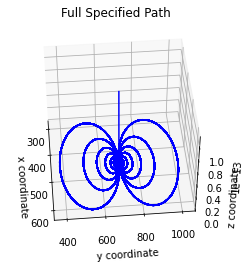

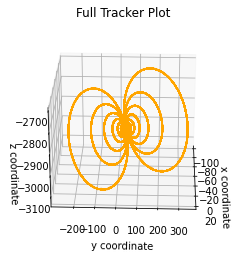

In [167]:
figure = plt.figure()
ax = plt.axes(projection='3d')


ax.plot3D(pth_x, pth_y, pth_z, 'blue')
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
ax.set_title('Full Specified Path')
ax.view_init(45, -5)
plt.show()

figure = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(trk_y, -trk_x, trk_z, 'orange')
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
ax.set_title('Full Tracker Plot')
ax.view_init(25, 2)
plt.show()



# Visualize the Specified Path and the Tracker Path
The specified path exists solely in the $xy$ plane, so we first plot the $x$ and $y$ coordinates of the specified path onto 2-Dimensions (See Figure 1 below). Here we see many loops (as expected from what was written in README.md) which all share a common point in the middle of the plot. If we go ahead and create the same plot for the tracker path (See Figure 2 below) we clearly see the same form of many loops but with a clear transformation performed. There appears to be a translation in the $x$ and $y$ directions as well as some rotation and skew. As shown in Figure 3 below, the transformation becomes apparent when the two sets of $xy$ coordinates are plotted onto the same axis. Due to the similar shape, we could go ahead and find a transformation matrix $A$ such that  we can represent the transformation $T$ as $T(\vec{x}) = A\vec{x}$ where $\vec{x}$ is a coordinate in the $xyz$ plane from the specified path. However, in this notebook, the exact transformation matrix tells us exactly how the points get transformed but provides less in terms of where these errors might come from. So, we are going to skip the calculation of the transformation matrix $A$ in preference of analysis of how the different coordinates between the path and tracker correlate and look for insights there.  

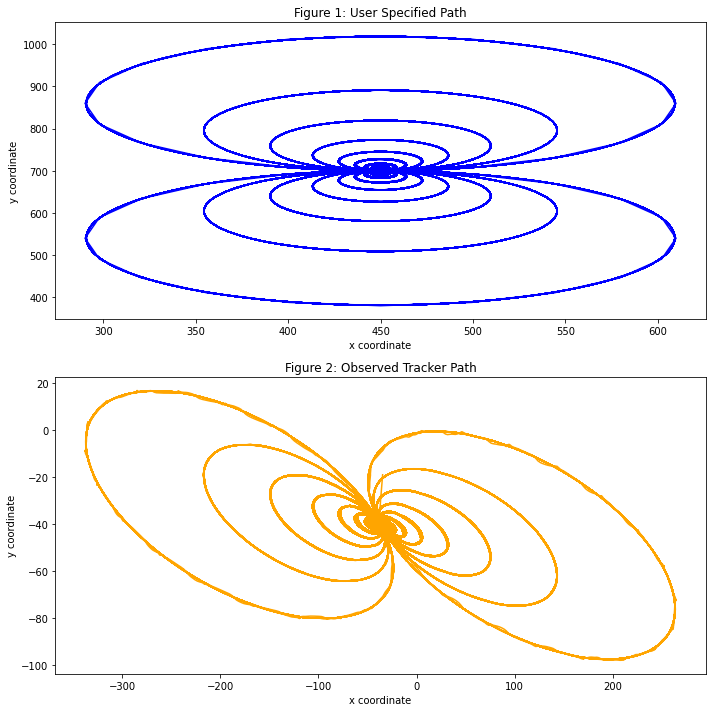

In [181]:
# EXPLORE DESIRED SPECIFIED PATH AND OBSERVED TRACKED PATH

figure, axes = plt.subplots(2,1, figsize=(10,10))

plt1 = axes[0]
plt1.plot(pth_x, pth_y, c='blue')
plt1.set_xlabel('x coordinate')
plt1.set_ylabel('y coordinate')
plt1.set_title('Figure 1: User Specified Path')

plt2 = axes[1]
plt2.plot(trk_x, trk_y, c='orange')
plt2.set_xlabel('x coordinate')
plt2.set_ylabel('y coordinate')
plt2.set_title('Figure 2: Observed Tracker Path')

# save and show figs
plt.tight_layout()
plt.savefig('./figs/figures12_individual_xy.png', facecolor='white')
plt.show()


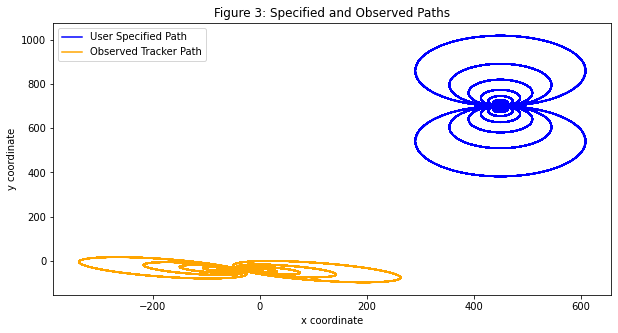

In [182]:
# PLOT PATH AND TRACKER ON SAME AXIS

# create figure to plot onto
figure, ax = plt.subplots(1,1, figsize=(10,5))

# plot points
ax.plot(pth_x, pth_y, c='blue', label='User Specified Path')
ax.plot(trk_x, trk_y, color='orange', label='Observed Tracker Path')
# label figure
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_title('Figure 3: Specified and Observed Paths')
ax.legend()
# save and show figure
plt.savefig("./figs/figure3_combined_xy.png", facecolor='white')
plt.show()

# Specified Path Analysis
Here in Figures 4, 5, and 6 we visualize how the $x$, $y$, and $z$ coordinates of the specified path, respectively, vary based on time. Since the path specifies multiple loops in the $xy$ plance we see multiple sinusodial-like functions with changing amaplitudes and frequencies for the $x$ vs time and $y$ vs time Figures. For the $z$ vs time figure, we see the inital point being a very small non-zero value and the remaining values all being 0.  

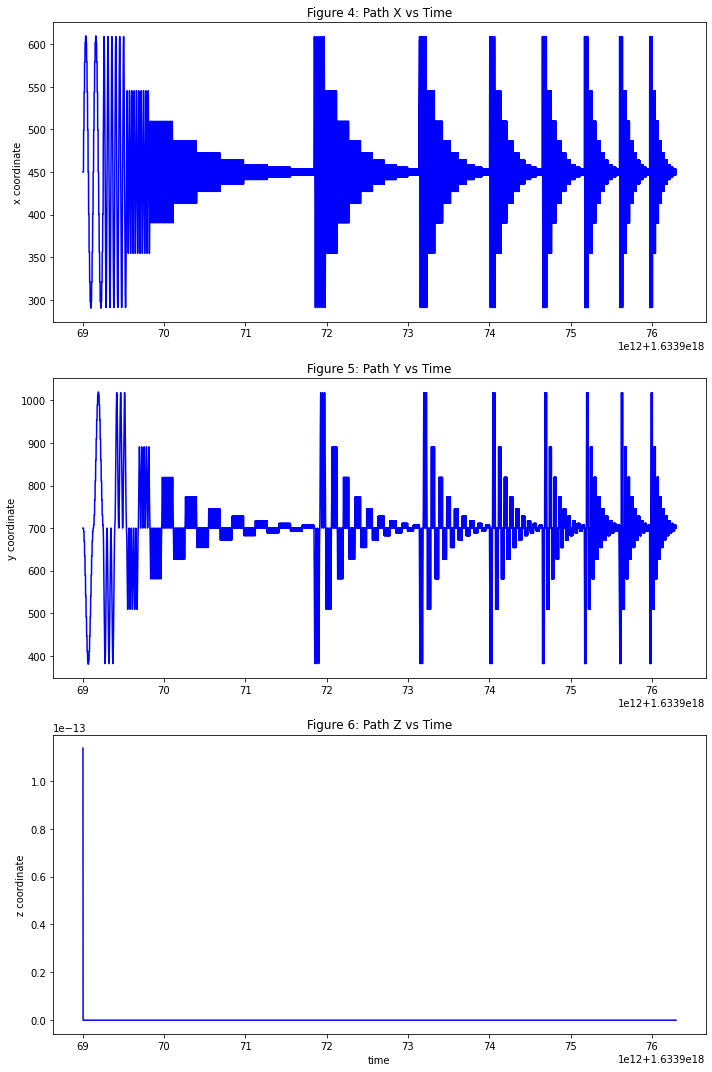

In [176]:
# EXPLORE SPECIFIED PATH VS TIME

# create figure to plot onto
fig, ax = plt.subplots(3,1, figsize=(10,15))

# plot and label figure for x coord vs time 
plt1 = ax[0]
plt1.plot(pth_t, pth_x, c='blue')
plt1.set_ylabel('x coordinate')
plt1.set_title('Figure 4: Path X vs Time')

# plot and label figure for z coord vs time 
plt2 = ax[1]
plt2.plot(pth_t, pth_y, c='blue')
plt2.set_ylabel('y coordinate')
plt2.set_title('Figure 5: Path Y vs Time')

# plot and label figure for z coord vs time 
plt3 = ax[2]
plt3.plot(pth_t, pth_z, c='blue')
plt3.set_xlabel('time')
plt3.set_ylabel('z coordinate')
plt3.set_title('Figure 6: Path Z vs Time')

# show plot
plt.tight_layout()
plt.savefig("./figs/figures456_Pvt.png", facecolor='white')
plt.show()

# Tracker Path Analysis
Here in figures 7, 8, and 9 we visualize how the $x$, $y$, and $z$ coordinates of the tracker path, respectively, vary based on time. Similar to the figures about for the specified path, we see sinusodial-like functions for $x$ vs time and $y$ vs time, but they vary from the plots we see for $x$ vs time and $y$ vs time for the specified path. We'll explore the difference more in detail deeper in the notebook, but the changes in amplitudes (and not by a uniform scalar) are the major difference you can see by eye between the specified and tracker paths. Further, here we see another sinusodial like function for the $z$ coordinate which drastically varies from what we see with the specified path. The $z$ vs time graph looks very similar to the $y$ vs time figure which is drastically different from the specified path $z$ vs time. 

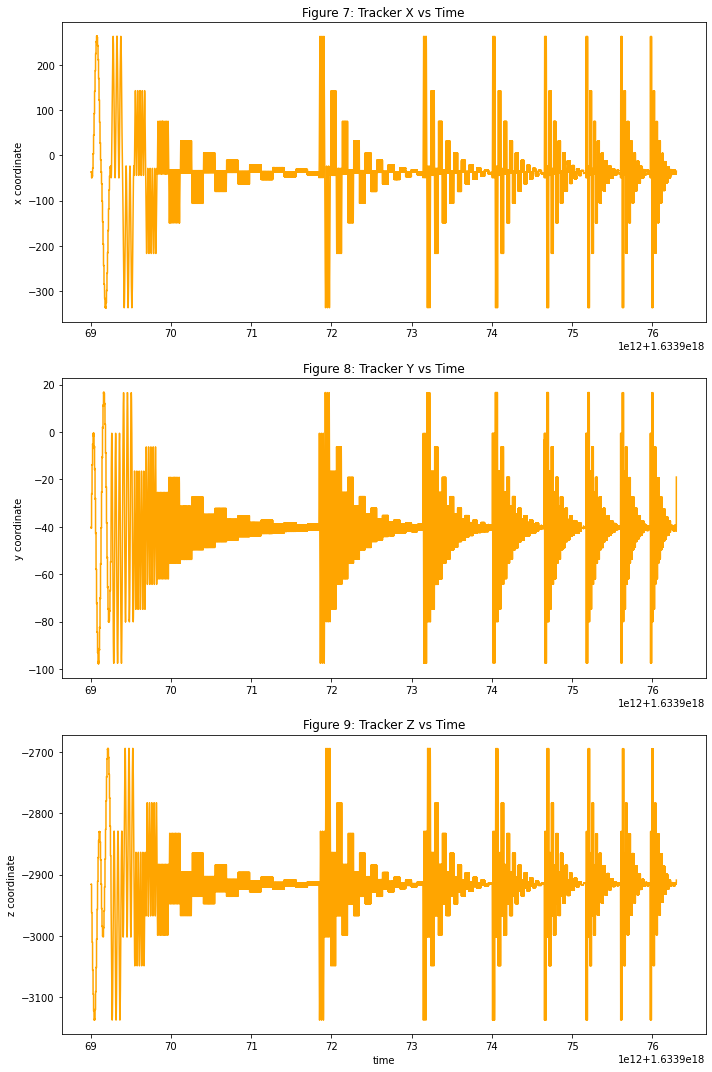

In [175]:
# EXPLORE TRACKER COORDINATES VS TIME
fig, ax = plt.subplots(3, 1, figsize=(10,15))

plt1 = ax[0]
plt1.plot(trk_t, trk_x, c='orange')
plt1.set_ylabel('x coordinate')
plt1.set_title('Figure 7: Tracker X vs Time')

plt2 = ax[1]
plt2.plot(trk_t, trk_y, c='orange')
plt2.set_ylabel('y coordinate')
plt2.set_title('Figure 8: Tracker Y vs Time')

plt3 = ax[2]
plt3.plot(trk_t, trk_z, c='orange')
plt3.set_xlabel('time')
plt3.set_ylabel('z coordinate')
plt3.set_title('Figure 9: Tracker Z vs Time')

plt.tight_layout()
plt.savefig("./figs/figures789_Tvt.png", facecolor='white')
plt.show()

# Exploring Coordinates vs Time
To begin to create insights on why the tracker path has errors, we will use the coordinate vs time plots above to begin to explore how the specified path points relate to the observed tracker coordinates. In expectation, we'd expect the path $x$ coordinates to line up with the tracker x coordinates and the same for the $y$ and $z$ coordinates as well. We first calculate simple translations between the path and tracker coordinates to make comparisons easier. We also zoom in on the first set of loops to be better able to see smaller discrepancies. 

In [185]:
# Find the ratio of specified points vs tracked points to plot subsets of roughly the same size
path_size = pth_t.size
tracker_size = trk_t.size
size_ratio = tracker_size / path_size

# specify the size of subsets to plot for following plots
num_points = 50000
trk_num_points = round(num_points*size_ratio)

# find trnaslations in x, y, and z directions to be able to compare amplitudes more easily
x_translation = pth_x[0] - trk_x[0]
y_translation = pth_y[0] - trk_y[0]
z_translation = pth_z[0] - trk_z[0]

# calculate and store translated tracker path coordinates
trk_x_t = trk_x + x_translation
trk_y_t = trk_y + y_translation
trk_z_t = trk_z + z_translation

## X Coordinate
Here we again see the $x$ vs time plots for both the path and tracker (these are the same figures shown above in different groups). These plots, over roughly the same time domain, have very few similarities. The $x$ coordinate range at different subsets of the time, are completely different and the pattern seen is noticeably different. Also, if we approximate the range of the plotted points on each plot by looking at the graph, the range of the path $x$ coordinate seems to be roughly 300 while the range of the tracker $x$ coordinate seems to be roughly 600. This could be the result of some scaling of around 2, but we'll reassess after exploring the other coordinates. 

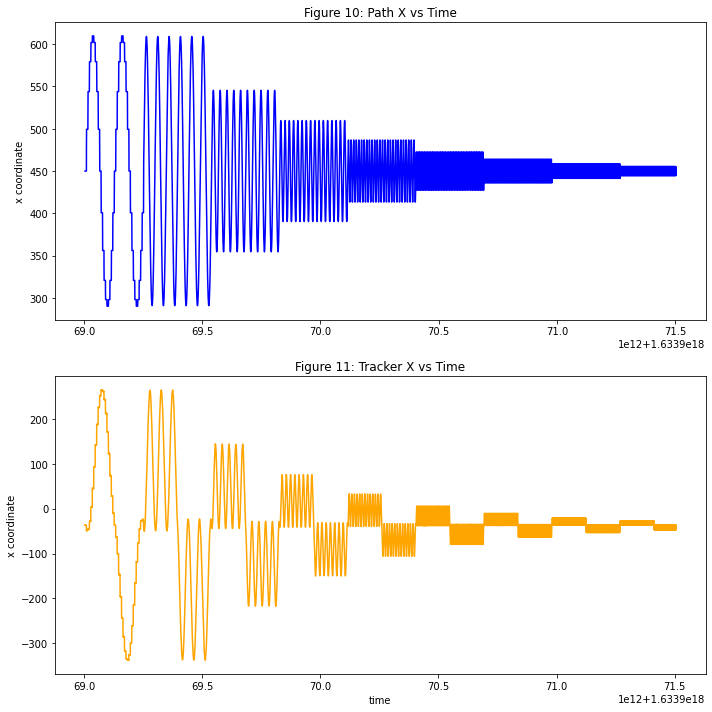

In [187]:
# create figure to plot onto
fig, ax = plt.subplots(2, 1, figsize=(10,10))

# plot path x coordinates
plt1 = ax[0]
plt1.plot(pth_t[:num_points], pth_x[:num_points], c='blue')
plt1.set_ylabel('x coordinate')
plt1.set_title('Figure 10: Path X vs Time')

# plot tracker x coordinates
plt2 = ax[1]
plt2.plot(trk_t[:trk_num_points], trk_x[:trk_num_points], c='orange')
plt2.set_xlabel('time')
plt2.set_ylabel('x coordinate')
plt2.set_title('Figure 11: Tracker X vs Time')

# save and show figure
plt.tight_layout()
plt.savefig('./figs/figures1011_XvT.png', facecolor='white')
plt.show()

## Y Coordinate
Here we made the same visualizations for the $y$ coordinates as we did with the $x$ coordinates. We see a very similar pattern as with the $x$ coordinate as the path $y$ vs time and the tracker $y$ vs time seem to have very little correlation. However, here we notice that the path $y$ vs time plot (figure 12) looks very similar to the tracker $x$ vs time (figure 11) and, to a lesser extent, the path $x$ vs time (figure 10) looks similar to the tracker $y$ vs time (figure 13). This could begin to provide an insight into how the translation errors occured between the specified path and the tracker path. Potentially, the $x$ and $y$ coordinates of the specified path got flipped when given to the robotic arm to follow. In general, this wouldn't necessarily be an arror if the arm is working on a uniform material as it'd have the same result just rotated and flipped with respect to the coordinate plane. If the material is not uniform, then this would cause errors and would be the first issue to look into. We explore the correlation between path $x$ and tracker $y$ and between path $y$ and tracker $x$ later in the notebook.   

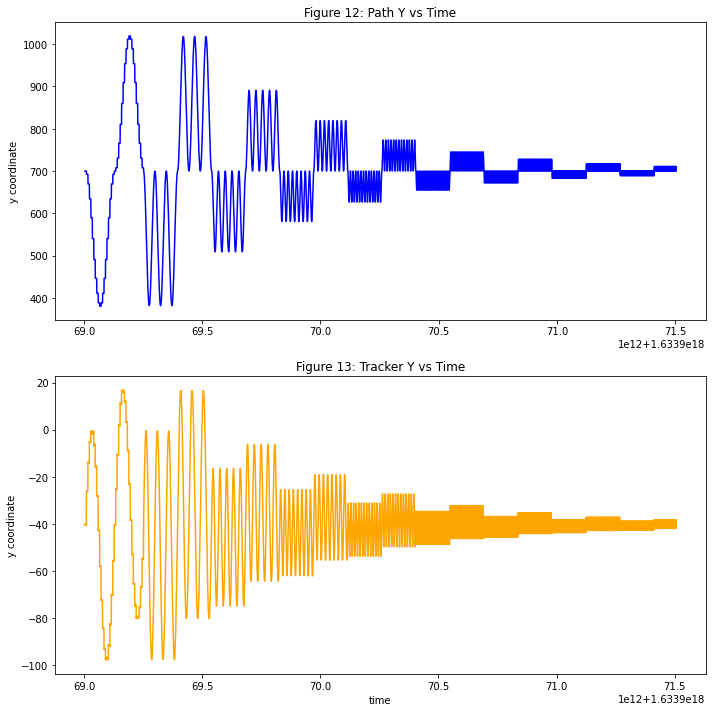

In [188]:
# create figure to plot onto
fig, ax = plt.subplots(2, 1, figsize=(10,10))

# plot path Y 
plt1 = ax[0]
plt1.plot(pth_t[:num_points], pth_y[:num_points], c='blue')
plt1.set_ylabel('y coordinate')
plt1.set_title("Figure 12: Path Y vs Time")

# plot tracker Y
plt2 = ax[1]
plt2.plot(trk_t[:trk_num_points], trk_y[:trk_num_points], c='orange')
plt2.set_xlabel('time')
plt2.set_ylabel('y coordinate')
plt2.set_title("Figure 13: Tracker Y vs Time")

# save and show figures
plt.tight_layout()
plt.savefig('./figs/figures1213_YvT.png', facecolor='white')
plt.show()


## Z Coordinate
Here we again explore the $z$ coordinate as we did with the $x$ and $y$ coordinates. Here we see the biggest discrepancy as the specified path has no $z$ coordinate values specified, but the tracker path $z$ coordinates follow a similar pattern to the $x$ and $y$ coordinates of the path and tracker. This suggests that there is some mistake in how the $x$ and $y$ coordinates from the specified path get communicated to, transformed by, and executed by the robotic arm. This probably provides some explaination as to why we see such a big skew on the tracker path in the $xy$ plane. More to come on this later in the notebook.  

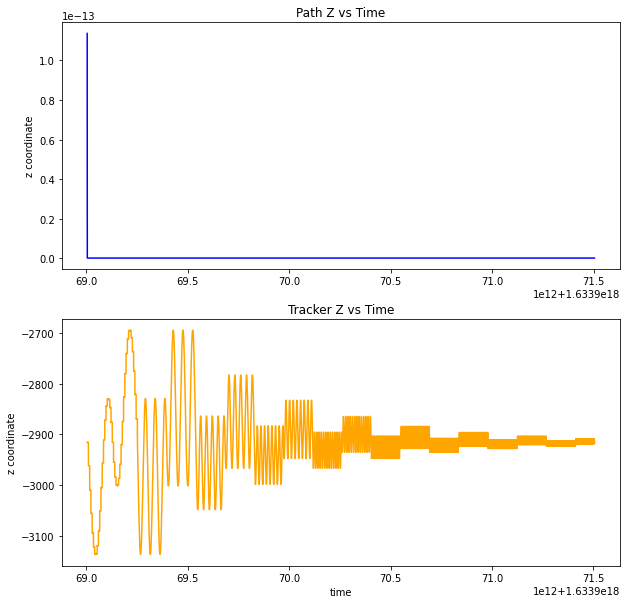

In [104]:
# create figure to plot onto
fig, ax = plt.subplots(2, 1, figsize=(10,10))

# plot path z vs time
plt1 = ax[0]
plt1.plot(pth_t[:num_points], pth_z[:num_points], c='blue')
plt1.set_ylabel('z coordinate')
plt1.set_title('Figure 14: Path Z vs Time')

# plot tracker z vs time
plt2 = ax[1]
plt2.plot(trk_t[:trk_num_points], trk_z[:trk_num_points], c='orange')
plt2.set_xlabel('time')
plt2.set_ylabel('z coordinate')
plt2.set_title('Figure 15: Tracker Z vs Time')

# save and show figures
plt.tight_layout()
plt.savefig('./figs/figures1415_ZvT.png', facecolor='white')
plt.show()


# Correlations Between Different Coordinates

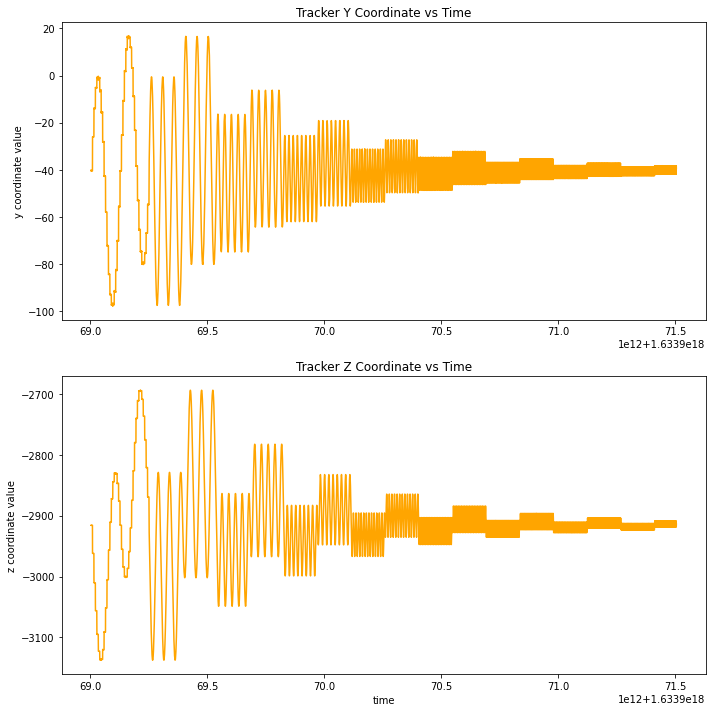

In [54]:
figure, axes = plt.subplots(2,1, figsize=(10,10))

plt1 = axes[0]
plt1.plot(trk_t[:trk_num_points], trk_y[:trk_num_points], c='orange')
#plt1.set_xlabel("time")
plt1.set_ylabel('y coordinate value')
plt1.set_title("Tracker Y Coordinate vs Time")


plt2 = axes[1]
plt2.plot(trk_t[:trk_num_points], trk_z[:trk_num_points], c='orange')
plt2.set_xlabel("time")
plt2.set_ylabel('z coordinate value')
plt2.set_title("Tracker Z Coordinate vs Time")

plt.tight_layout()
plt.show()
## these two plots show same exact trend

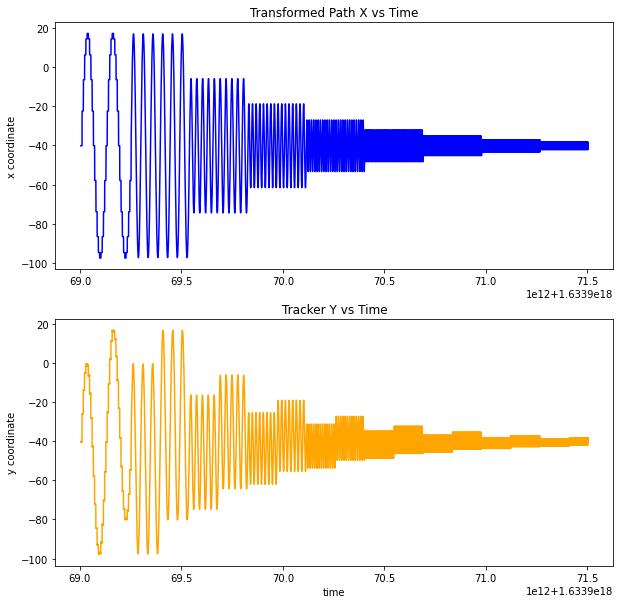

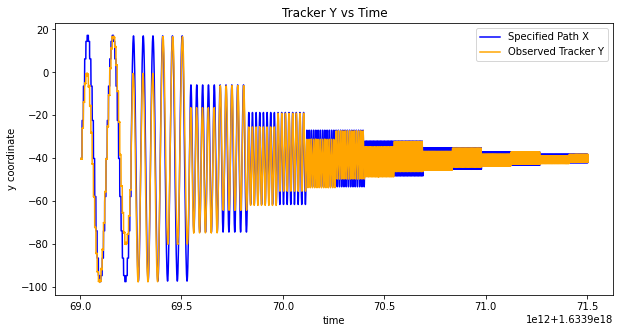

In [113]:
# first point of path y

range_pth = max(pth_x) - min(pth_x)
range_trk = max(trk_y) - min(trk_y)
rto = range_pth / range_trk

scaled_pth_x = pth_x[:num_points] / rto
first_point_diff = scaled_pth_x[0] - trk_y[0]
transformed_pth_x = scaled_pth_x - first_point_diff

fig, ax = plt.subplots(2, 1, figsize=(10,10))

plt1 = ax[0]
plt1.plot(pth_t[:num_points], transformed_pth_x[:num_points], c='blue')
plt1.set_ylabel('x coordinate')
plt1.set_title("Transformed Path X vs Time")

plt2 = ax[1]
plt2.plot(trk_t[:trk_num_points], trk_y[:trk_num_points], c='orange')
plt2.set_xlabel('time')
plt2.set_ylabel('y coordinate')
plt2.set_title("Tracker Y vs Time")
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(pth_t[:num_points], transformed_pth_x[:num_points], c='blue', label='Specified Path X')
ax.plot(trk_t[:trk_num_points], trk_y[:trk_num_points], c='orange', label='Observed Tracker Y')
ax.set_xlabel('time')
ax.set_ylabel('y coordinate')
ax.set_title("Tracker Y vs Time")
ax.legend()
plt.show()


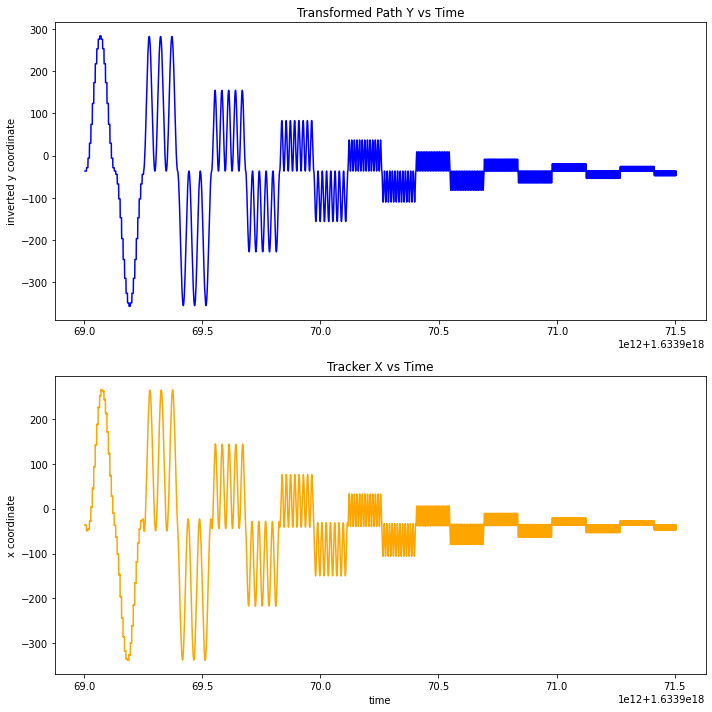

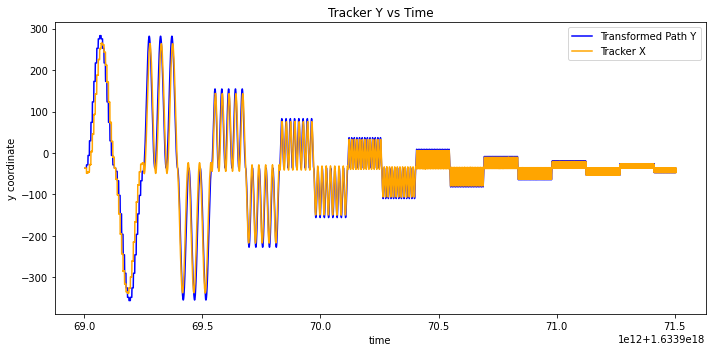

In [112]:
# first point of path y
range_pth = max(pth_y) - min(pth_y)
range_trk = max(trk_y) - min(trk_y)
rto = range_pth / range_trk

scaled_pth_x = pth_x[:num_points] / rto
first_point_diff = scaled_pth_x[0] - trk_y[0]
transformed_pth_x = scaled_pth_x - first_point_diff

first_point_diff = -1*pth_y[0] - trk_x[0]

transformed_pth_y = -1*pth_y[:num_points] - first_point_diff

fig, ax = plt.subplots(2, 1, figsize=(10,10))

plt1 = ax[0]
plt1.plot(pth_t[:num_points], transformed_pth_y, c='blue')
plt1.set_ylabel('inverted y coordinate')
plt1.set_title("Transformed Path Y vs Time")

plt2 = ax[1]
plt2.plot(trk_t[:trk_num_points], trk_x[:trk_num_points], c='orange')
plt2.set_xlabel('time')
plt2.set_ylabel('x coordinate')
plt2.set_title("Tracker X vs Time")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(pth_t[:num_points], transformed_pth_y, c='blue', label='Transformed Path Y')
ax.plot(trk_t[:trk_num_points], trk_x[:trk_num_points], c='orange', label='Tracker X')
ax.set_xlabel('time')
ax.set_ylabel('y coordinate')
ax.set_title("Tracker Y vs Time")
ax.legend()
plt.tight_layout()
plt.show()

# Zoomed In

In [ ]:
num_points = 1000

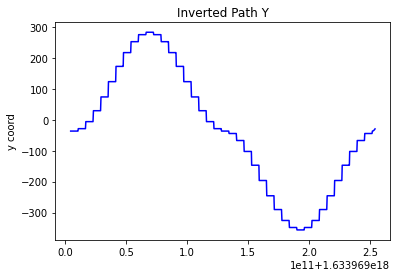

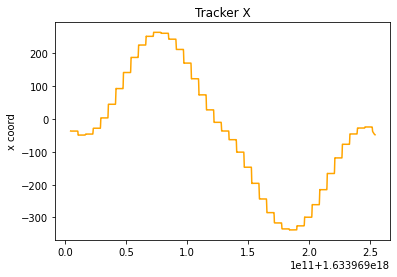

41.88627525280799


In [17]:
# first point of path y
first_point_diff = -1*pth_y_m[0] - trk_x_m[0]

transformed_pth_y_m = -1*pth_y_m[:num_points] - first_point_diff

plt.plot(pth_t_m[:num_points], transformed_pth_y_m, c='blue')
plt.ylabel('y coord')
plt.title("Inverted Path Y")
plt.show()

plt.plot(trk_t_m[:num_points], trk_x_m[:num_points], c='orange')
plt.ylabel('x coord')
plt.title("Tracker X")
plt.show()


print(mae(transformed_pth_y_m, trk_x_m[:num_points]))

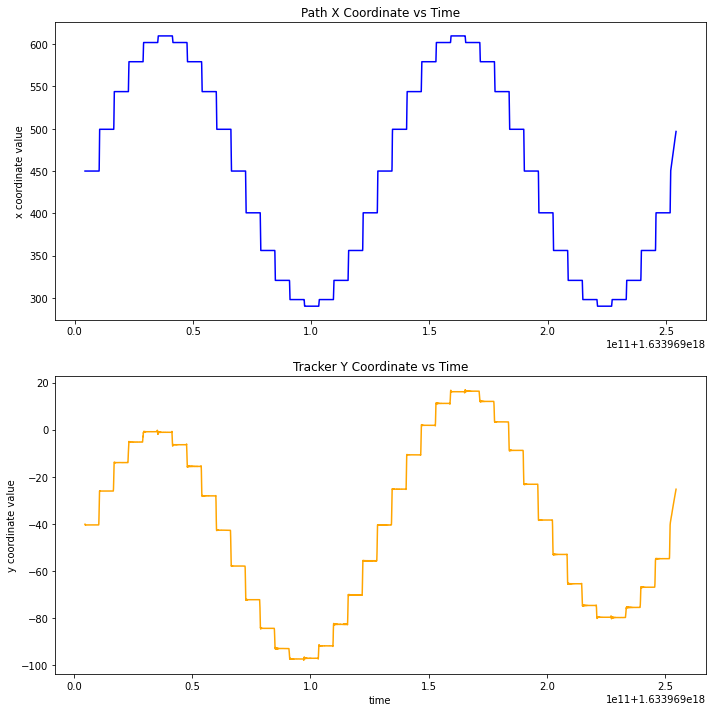

Range of Path X:
Max value:  609.8113305374916
Min value:  290.18866946250847
Range:  319.6226610749831

Range of Tracker Y:
Max value:  16.84531593322754
Min value:  -97.96622467041016
Range:  114.8115406036377


In [18]:
figure, axes = plt.subplots(2,1, figsize=(10,10))

plt1 = axes[0]
plt1.plot(pth_t[:num_points], pth_x[:num_points], c='blue')
#plt1.set_xlabel("time")
plt1.set_ylabel('x coordinate value')
plt1.set_title("Path X Coordinate vs Time")

plt2 = axes[1]
plt2.plot(trk_t[:trk_num_points], trk_y[:trk_num_points], c='orange')
plt2.set_xlabel("time")
plt2.set_ylabel('y coordinate value')
plt2.set_title("Tracker Y Coordinate vs Time")

plt.tight_layout()
plt.show()

print("Range of Path X:")
print("Max value: ", max(pth_x[:num_points]))
print("Min value: ", min(pth_x[:num_points]))
print("Range: ", max(pth_x[:num_points]) - min(pth_x[:num_points]))

print("\nRange of Tracker Y:")
print("Max value: ", max(trk_y[:trk_num_points]))
print("Min value: ", min(trk_y[:trk_num_points]))
print("Range: ", max(trk_y[:trk_num_points]) - min(trk_y[:trk_num_points]))

# Path Followed vs Time

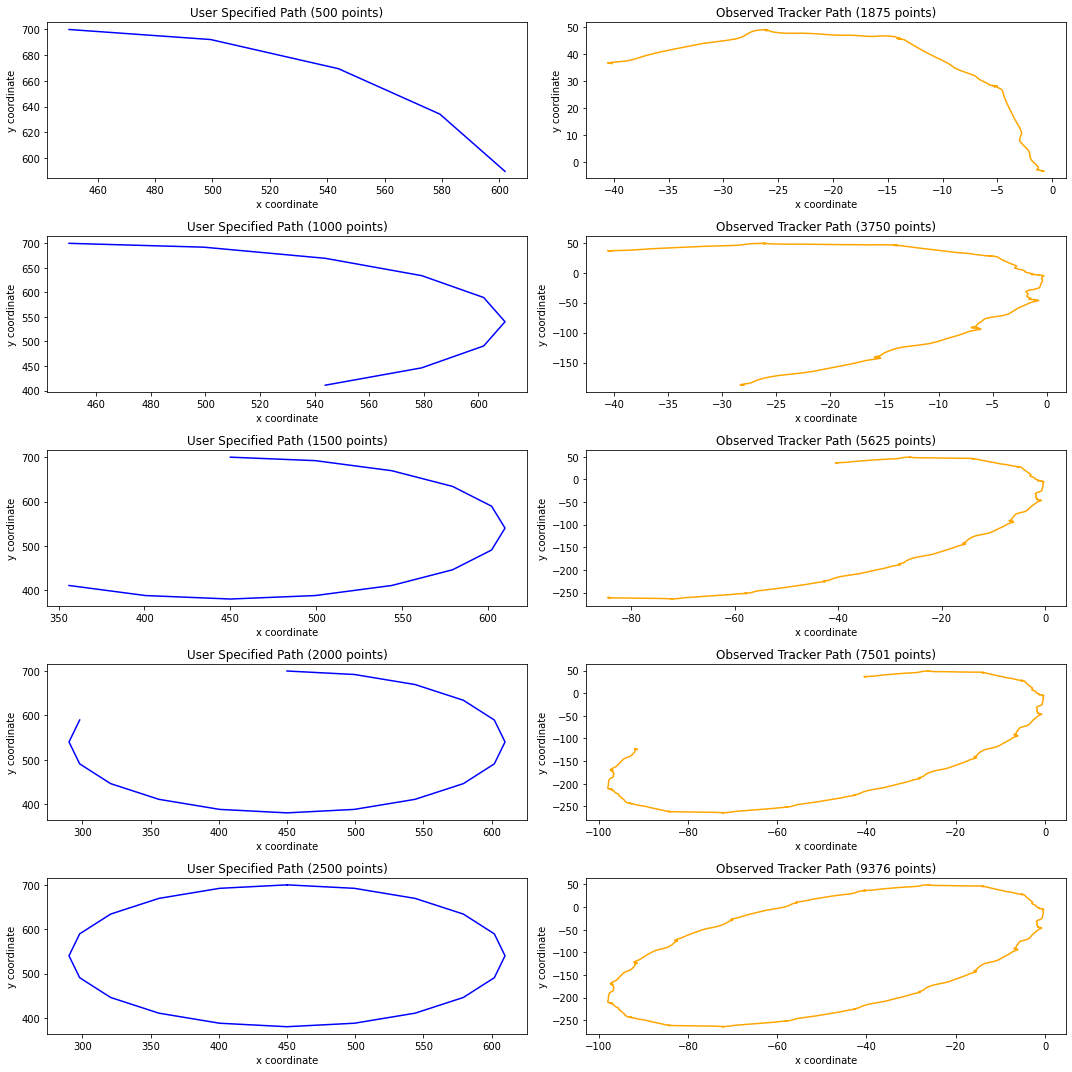

In [122]:

fig, ax = plt.subplots(5,2, figsize=(15,15))

for i in range(0, 5):
    num_points = 500*i + 500
    plt0 = ax[i][0]
    plt0.plot(pth_x[:num_points], pth_y[:num_points], c='blue')
    plt0.set_xlabel("x coordinate")
    plt0.set_ylabel('y coordinate')
    title0 =  "User Specified Path (" + str(num_points) + " points)"
    plt0.set_title(title0)

    trk_num_points = round(num_points*size_ratio)
    plt1 = ax[i][1]
    plt1.plot(trk_y[:trk_num_points], -trk_x[:trk_num_points], c='orange')
    plt1.set_xlabel("x coordinate")
    plt1.set_ylabel('y coordinate')
    title1 = "Observed Tracker Path (" + str(trk_num_points) + " points)"
    plt1.set_title(title1)

plt.tight_layout()
plt.show()

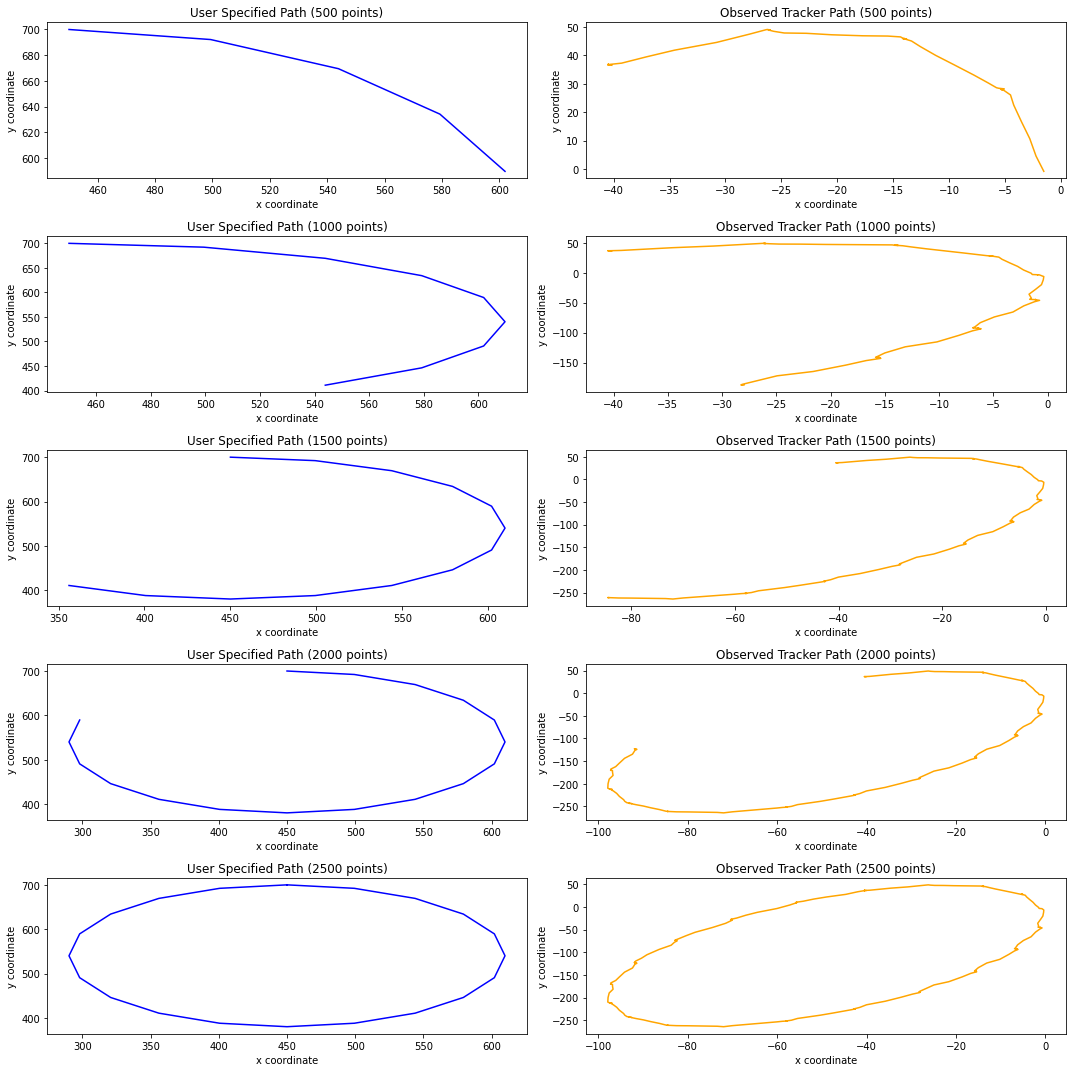

In [123]:

fig, ax = plt.subplots(5,2, figsize=(15,15))

for i in range(0, 5):
    num_points = 500*i + 500
    plt0 = ax[i][0]
    plt0.plot(pth_x[:num_points], pth_y[:num_points], c='blue')
    plt0.set_xlabel("x coordinate")
    plt0.set_ylabel('y coordinate')
    title0 =  "User Specified Path (" + str(num_points) + " points)"
    plt0.set_title(title0)

    trk_num_points = round(num_points*size_ratio)
    plt1 = ax[i][1]
    plt1.plot(trk_y_m[:num_points], -trk_x_m[:num_points], c='orange')
    plt1.set_xlabel("x coordinate")
    plt1.set_ylabel('y coordinate')
    title1 = "Observed Tracker Path (" + str(num_points) + " points)"
    plt1.set_title(title1)

plt.tight_layout()
plt.show()